# Milestone : Pytorch Paper Replicating

The goal of machine learning research paper is: turn a ML research paper into usable code


## Setup Base Code

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get data

In [4]:

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from going_modular.going_modular import data_setup

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e915d7d74d0>,
 ['pizza', 'steak', 'sushi'])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

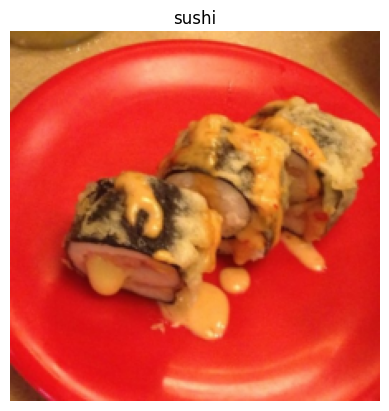

In [8]:
## Visualize a single Image
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [9]:
# Replicating ViT: Overview



https://github.com/mrdbourke/pytorch-deep-learning/blob/main/08_pytorch_paper_replicating.ipynb

# Equation 1 : Split data into patches and creating the class, position and patch embedding


Input shape: (224,224, 3) -> single image -> (heights, width, color channels)

Output shape:

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate the number of patches
num_patches = int((height*width)/patch_size**2)
num_patches

196

In [11]:
#Input shape
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)


(224, 224, 3)
(196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

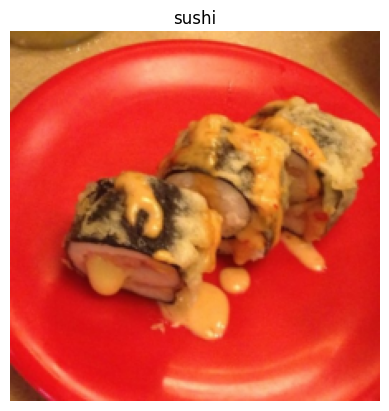

In [12]:
### 4.2 Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)


In [13]:
image.shape

torch.Size([3, 224, 224])

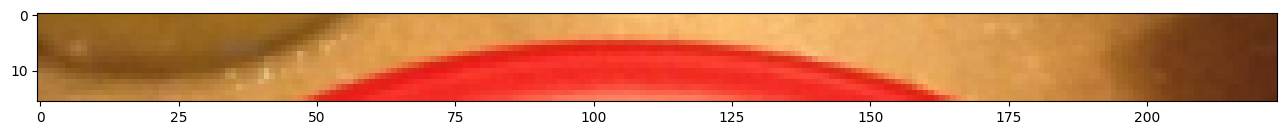

In [14]:
#Get the top row of the image
image_permuted = image.permute(1,2,0)

#Index to plot the top row
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])


Number of patches per row: 14.0 
 Patch size: 16 pixels x 16 pixels


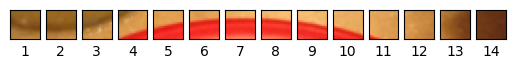

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size,
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
        axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
        axs[i].set_xlabel(i+1)
        axs[i].set_xticks([])
        axs[i].set_yticks([])



Number of patches per row: 14.0 
 Patch size: 16 pixels x 16 pixels


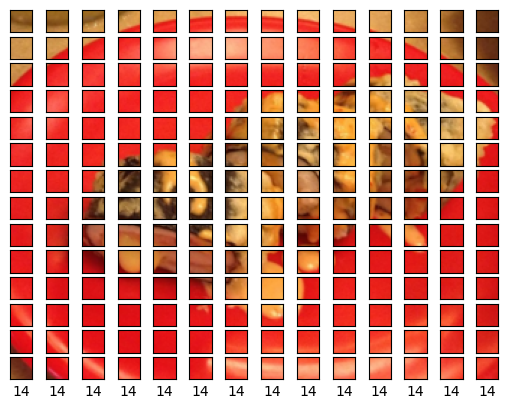

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i,j].set_xlabel(i+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])



#Creating Image patches and turning them into patch embeddings

In [17]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [18]:
# Pass the image through the convolutional layer

image_out_of_conv = conv2d(image.unsqueeze(0)) #add batch dimensions -> (batch_size, color_channels,height, width)

print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [19]:
# image_out_of_conv = image_out_of_conv.reshape(1,768,14*14)

In [20]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [21]:
from torch import nn

patch_size = 16

#Create a Conv2d layer with hyperparams from the VIT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Showing random convolutional feature maps from indexes: [200, 353, 206, 726, 494]


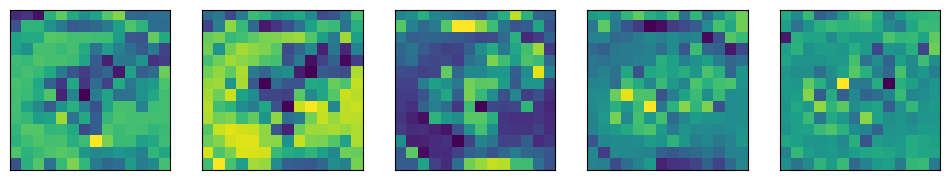

In [22]:

# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [23]:

# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.1252, 0.0916, 0.0989, 0.2097, 0.2616, 0.2252, 0.2378, 0.2424,
           0.3109, 0.2177, 0.1864, 0.2273, 0.1971, 0.1221],
          [0.1831, 0.2323, 0.1829, 0.1683, 0.1400, 0.1519, 0.1728, 0.1798,
           0.2015, 0.2474, 0.2860, 0.2790, 0.1728, 0.1458],
          [0.2289, 0.2018, 0.2244, 0.2326, 0.2455, 0.2425, 0.2394, 0.2388,
           0.2131, 0.2471, 0.1007, 0.2452, 0.2130, 0.1925],
          [0.1597, 0.2214, 0.2334, 0.2222, 0.2248, 0.2325, 0.2562, 0.2135,
           0.1000, 0.1646, 0.1390, 0.1833, 0.1805, 0.2938],
          [0.2137, 0.2467, 0.2151, 0.2219, 0.2328, 0.2751, 0.1403, 0.2195,
           0.0428, 0.2454, 0.3134, 0.0697, 0.2182, 0.3189],
          [0.2195, 0.2243, 0.2479, 0.2404, 0.1022, 0.2557, 0.0691, 0.0910,
           0.0749, 0.1429, 0.2399, 0.2581, 0.1833, 0.2265],
          [0.2234, 0.2266, 0.2144, 0.0340, 0.2358, 0.2362, 0.0588, 0.2900,
           0.1731, 0.2162, 0.2276, 0.1455, 0.1805, 0.2435],
          [0.2142, 0.2365, 0.1932, 0.1885, 0.1519, 0.18

# Flattening the patch embedding

In [24]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape


torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


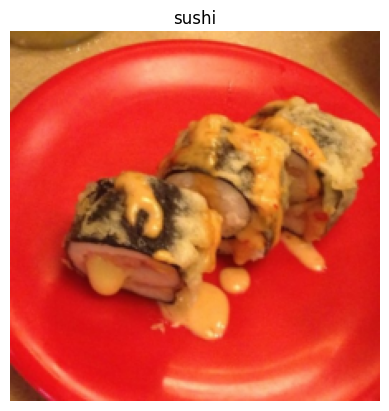

In [25]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)

In [27]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map

tensor([[-0.0833, -0.0757, -0.1189, -0.2680, -0.2130, -0.1855, -0.1513, -0.1593,
         -0.2165, -0.2910, -0.2261, -0.2219, -0.1709, -0.1054, -0.2165, -0.3262,
         -0.1771, -0.1033, -0.1653, -0.2560, -0.2746, -0.2460, -0.2069, -0.1449,
         -0.1443, -0.1771, -0.1572, -0.1172, -0.2858, -0.1063, -0.1339, -0.1348,
         -0.1533, -0.1429, -0.1329, -0.1264, -0.1336, -0.1369, -0.0237, -0.0504,
         -0.1467, -0.1656, -0.0787, -0.1643, -0.1285, -0.1071, -0.1006, -0.1145,
         -0.0631, -0.1489, -0.1312, -0.0902, -0.2519, -0.2692, -0.1621, -0.0856,
         -0.1243, -0.1623, -0.1064, -0.1082, -0.1148, -0.1094, -0.1150, -0.1767,
         -0.0727, -0.1929, -0.2622, -0.2369, -0.2006, -0.3359, -0.1220, -0.1186,
         -0.1084, -0.1968, -0.0966, -0.2418, -0.0785, -0.1147, -0.3495, -0.1941,
         -0.2027, -0.0913, -0.2459, -0.1974, -0.1130, -0.0993, -0.0712, -0.0200,
         -0.1072, -0.1629, -0.0815, -0.1137, -0.1902, -0.1924, -0.1851, -0.0833,
         -0.1213, -0.1025, -

# Turning the VIT patch embedding layer into a pytorch module

We want this module to do a few things:
1. Create a class called "PatchEmbedding"
2. Initialize with approapriate hyperpaarams
3. Create a layer to turn an image into embedding patches using "nn.Conv2s()"
4. Create a layer to flatten the feature maps of the output of th layer in 3.
5. Define a forward() that defines the forward computation
6. Make sure the output shape of the layer reflexts the required output shape of the patch embedding

In [28]:
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        self.conv_embed = nn.Conv2d(
            in_channels = in_channels,
            out_channels= embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
    def forward(self,image):
        #Create assertion to check that inputs are correct shape
        image_resolution = image.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        image = self.conv_embed(image)
        image_flat = self.flatten(image)
        image_flat = image_flat.permute(0,2,1)
        return image_flat

patch_layer = PatchEmbedding()
image_batch = torch.rand((32,3,224,224))
patch_output = patch_layer(image_batch)
patch_output.shape


torch.Size([32, 196, 768])

In [29]:
patch_layer = PatchEmbedding(in_channels=3,
                             patch_size=16,
                             embedding_dim=768)
image_batch = torch.rand((1,3,224,224))
patch_output = patch_layer(image_batch)
patch_output.shape

torch.Size([1, 196, 768])

In [30]:
patch_output

tensor([[[ 0.2185, -0.3839, -0.5017,  ..., -0.0846,  0.2173, -0.2380],
         [-0.1452, -0.3715,  0.2612,  ..., -0.0541,  0.3876, -0.5554],
         [-0.5333, -0.0954,  0.1341,  ..., -0.4083,  0.2955, -0.5358],
         ...,
         [-0.3328, -0.2078, -0.0537,  ...,  0.0955,  0.2909, -0.4952],
         [-0.1073, -0.2264, -0.0378,  ..., -0.2087, -0.1644, -0.8631],
         [-0.0482, -0.0743, -0.2138,  ..., -0.1208,  0.2846, -0.3132]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_output.shape[0]
embedding_dimension = patch_output.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
#Create class token embedding as learnable parameter that shares
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_output.shape

torch.Size([1, 196, 768])

In [34]:
#Add the class token embedding at the beginning of the patch

patch_output_with_class = torch.cat((class_token, patch_output),
                                    dim=1) #Number of patches dimension

print(patch_output_with_class)


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2185, -0.3839, -0.5017,  ..., -0.0846,  0.2173, -0.2380],
         [-0.1452, -0.3715,  0.2612,  ..., -0.0541,  0.3876, -0.5554],
         ...,
         [-0.3328, -0.2078, -0.0537,  ...,  0.0955,  0.2909, -0.4952],
         [-0.1073, -0.2264, -0.0378,  ..., -0.2087, -0.1644, -0.8631],
         [-0.0482, -0.0743, -0.2138,  ..., -0.1208,  0.2846, -0.3132]]],
       grad_fn=<CatBackward0>)


In [35]:
## 4.7 Creating position embedding
#view the sequence of patch embeddings with the prepended class embedding
patch_output_with_class.shape


torch.Size([1, 197, 768])

In [36]:
number_of_patches = int((height * width)/patch_size**2)

embedding_dimension = patch_output_with_class.shape[-1]

position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# add the position embedding to the patch and class token embedding

patch_position_em = patch_output_with_class + position_embedding

patch_position_em, patch_position_em.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.2185, 0.6161, 0.4983,  ..., 0.9154, 1.2173, 0.7620],
          [0.8548, 0.6285, 1.2612,  ..., 0.9459, 1.3876, 0.4446],
          ...,
          [0.6672, 0.7922, 0.9463,  ..., 1.0955, 1.2909, 0.5048],
          [0.8927, 0.7736, 0.9622,  ..., 0.7913, 0.8356, 0.1369],
          [0.9518, 0.9257, 0.7862,  ..., 0.8792, 1.2846, 0.6868]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
## Putting it all together: from image to embedding

In [39]:
# Set Seeds
set_seeds()

#Set the patch size
patch_size = 16

#Print shapes of the original image tensor and get the image dimensions
print(f"Image Tensor Shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

#Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape:{x.shape}")

#Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size = patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Layer output: {patch_embedding.shape}")

#Creating class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)

print(f"Class Token embedding shape: {class_token.shape}")

#Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch Embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height*width)/patch_size **2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and postion Embedding shape: {patch_and_position_embedding.shape}")




Image Tensor Shape: torch.Size([3, 224, 224])
Input image shape:torch.Size([1, 3, 224, 224])
Patch Embedding Layer output: torch.Size([1, 196, 768])
Class Token embedding shape: torch.Size([1, 1, 768])
Patch Embedding with class token shape: torch.Size([1, 197, 768])
Patch and postion Embedding shape: torch.Size([1, 197, 768])


In [40]:
# class MultiHeadSelfAttentionBlock(nn.Module):
#     def __init__(self, embed_dim, num_heads):
#         super().__init__()
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
#         self.qkv = nn.Linear(self.embed_dim,self.embed_dim*3)
#         self.layernorm = nn.LayerNorm(embed_dim)

#     def forward(self,input):
#         x = self.layernorm(input)
#         qkv_vals = self.qkv(x)
#         q, k, v = torch.split(qkv_vals,3,2)
#         attn_output, attn_output_weights = self.multihead_attn(q,k,v)
#         output = attn_output + input
#         return output

# x = torch.randn((1,197,768))
# x.shape

# msa = MultiHeadSelfAttentionBlock(768,6)
# attout = msa(x)
# attout

In [41]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        #Create the norm layer (LN)
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mutihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True) #(batch,seq,feature)

    def forward(self,x):
        temp = x
        x = self.layer_norm(x)
        attn_output, _ = self.mutihead_attn(x,x,x)
        return attn_output + temp

msa = MultiHeadSelfAttentionBlock(768,12,0)
print(patch_and_position_embedding.shape)
attout = msa(patch_and_position_embedding)
print(attout.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Equation 3: Multilayer Perceptron

In [42]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim: int= 768,
                mlp_size: int =3072,
                dropout: int=0.1,
                ):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x



In [43]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

mlpout = mlp_block(attout)
print(attout.shape)
print(mlpout.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [44]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: int=0.1,
                 attn_dropout: int=0):
        super().__init__()

        #Create MSA Block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads = num_heads,
            attn_dropout = attn_dropout
        )

        #Create MLP Block (equation 3)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout = mlp_dropout
        )


    def forward(self,x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [45]:
#Create an instance of encoder
transformer_encoder_block = TransformerEncoderBlock()

summary(model = transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (mutihead_attn)          [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [46]:
# Using pytorch inbuilt

encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                           nhead=12,
                                           dim_feedforward=3072,
                                           dropout=0.1,
                                           activation="gelu",
                                           batch_first=True,
                                           norm_first=True
                                           )

In [47]:
summary(model = encoder_layer,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# Putting it all together to create VIT

In [48]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers:int=12,
                 embedding_dim: int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1,
                 num_classes:int=1000
                 ):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image {img_size}, patch size: {patch_size}"

        #Calculate the number of patches
        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True
                                            )
        #Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim))

        #Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        #Create the transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout)for _ in range(num_transformer_layers)])

        #Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        #Get the batch size
        batch_size = x.shape[0]

        #Create class token embedding
        class_token = self.class_embedding.expand(batch_size, -1,-1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token,x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:,0])

        return x

In [49]:
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=1000)

vit(random_image_tensor)

tensor([[ 3.3929e-01,  1.1637e+00,  1.1319e+00,  2.6466e-01, -5.9722e-01,
          2.9365e-01, -5.3806e-01,  3.2357e-02, -2.0107e-01,  5.7884e-01,
         -8.3065e-02,  4.3457e-01, -8.0794e-01, -2.2199e-01, -1.1514e+00,
         -3.6449e-01, -4.1234e-01, -1.4012e+00,  7.1468e-01,  2.5059e-01,
          6.9063e-01,  7.1611e-01, -7.1134e-03, -6.8844e-01,  7.0456e-01,
         -1.1780e-01,  1.7201e-01,  1.3777e-01, -3.3929e-01, -2.7924e-01,
         -3.9325e-01, -2.6170e-01,  3.4157e-01,  4.2428e-01,  4.1382e-01,
         -4.4961e-01, -2.6926e-01, -3.2148e-02, -1.1345e+00,  1.6588e-01,
         -1.0507e+00, -3.8488e-01, -1.8267e-01, -6.6315e-01, -5.7962e-02,
         -3.4714e-01, -3.9624e-02, -3.3164e-01,  8.0073e-01,  1.6613e-01,
         -4.8210e-01, -3.0699e-01,  1.0966e+00,  2.1213e-01,  3.9619e-01,
         -8.7276e-01,  1.4679e-02,  1.3375e-02, -1.0855e+00,  4.7448e-01,
         -1.3776e-01, -3.1753e-01, -9.2755e-02, -8.7817e-01,  1.7278e-01,
         -3.9575e-01, -1.0608e+00,  3.

In [50]:
from torchinfo import summary
summary(model = ViT(num_classes=3),
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv_embed)                              [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

# Setting up training code

In [51]:
# Create optimizer
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

#Create optimizer
loss_fn = torch.nn.CrossEntropyLoss()

#Training out ViT Model
from going_modular.going_modular import engine
results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs=10,
                       optimizer = optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1645 | train_acc: 0.3711 | test_loss: 2.6016 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.5337 | train_acc: 0.3086 | test_loss: 1.0862 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3173 | train_acc: 0.4141 | test_loss: 1.5697 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2507 | train_acc: 0.3125 | test_loss: 1.1391 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.2703 | train_acc: 0.3008 | test_loss: 1.6470 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1810 | train_acc: 0.4609 | test_loss: 1.1973 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.4357 | train_acc: 0.3008 | test_loss: 1.0905 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1519 | train_acc: 0.4141 | test_loss: 1.7925 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3551 | train_acc: 0.2891 | test_loss: 1.1167 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.2093 | train_acc: 0.3047 | test_loss: 1.1739 | test_acc: 0.5417


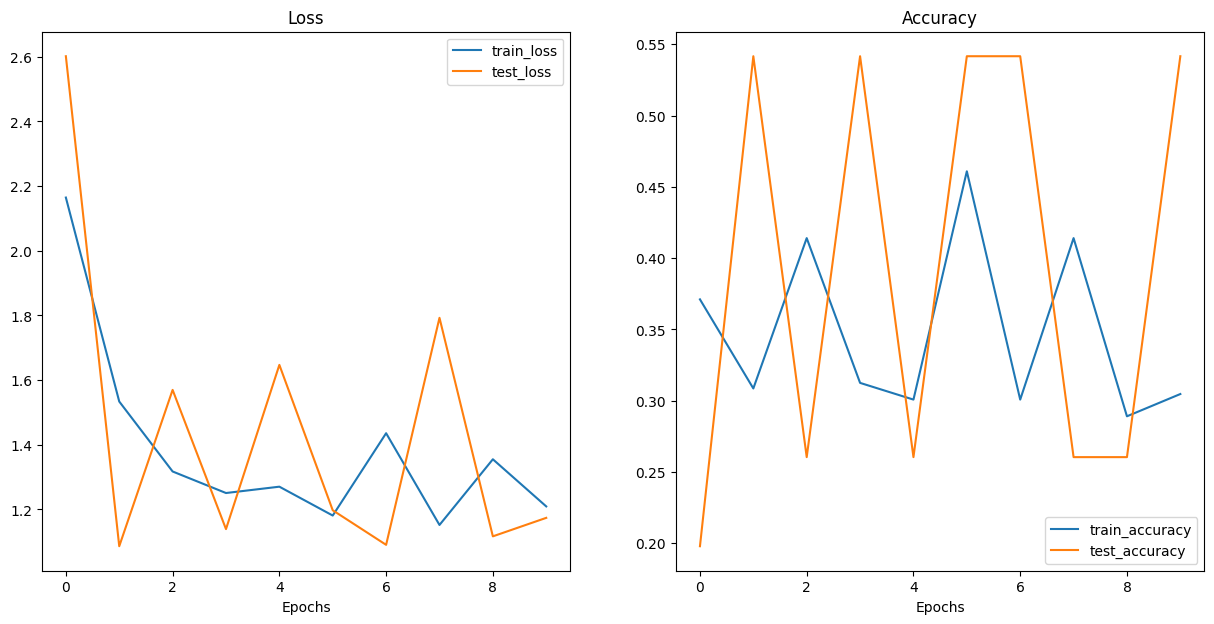

In [54]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)



In [55]:
#The model is underfitting and overfitting

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

pretrained_vit

In [62]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [63]:
from torchinfo import summary
summary(model = pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [64]:
from torchinfo import summary
summary(model = ViT(num_classes=3),
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv_embed)                              [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

In [65]:
## Preparing data for the pretrained ViT Model

# When using a pretrained ViT model.

vit_transforms = pretrained_vit_weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [69]:
#Setup dataloader
from going_modular.going_modular import  data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size=32)



In [70]:
from going_modular.going_modular import engine

optmizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                            lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader = train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn = loss_fn,
                                      epochs=10,
                                      device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1241 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 2 | train_loss: 1.1085 | train_acc: 0.3281 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 3 | train_loss: 1.1385 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 4 | train_loss: 1.1603 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 5 | train_loss: 1.1299 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 6 | train_loss: 1.0830 | train_acc: 0.3281 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 7 | train_loss: 1.1488 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 8 | train_loss: 1.1175 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 9 | train_loss: 1.2009 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282
Epoch: 10 | train_loss: 1.1278 | train_acc: 0.2070 | test_loss: 1.2487 | test_acc: 0.2282


In [71]:
## 10.6
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor.pth")


[INFO] Saving model to: models/08_pretrained_vit_feature_extractor.pth


In [74]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024)
pretrained_vit_model_size

327